# Hands On

It's recommendend to use [Anaconda](https://www.continuum.io/downloads) (Python 3.5)

Spyder:

1. File editors
1. Variable Explorer
1. Python Console

<img src="../resource/spyder.png" width=60%>

**Important Shortcuts (Windows)**

+ F5 - Run selected file
+ Ctrl+Space - Code completion
+ Ctrl+1 - Line comment
+ Ctrl+I - Show docs
+ Ctrl+Shift+I - Set focus on Console
+ Ctrl+Shift+V - Set focus on Variable Explorer
+ Ctrl+Shift+E - Set focus on File editor



## Exercise - Decline Curve Analysis

Based on sample 11.1 from the Book [Engenharia de Reservatórios de Petróleo](http://www.saraiva.com.br/engenharia-de-reservatorios-de-petroleo-198191.html) from Rosa, A. et al.*

>Decline curve analysis is a means of predicting future oil well production based on past production history. Production decline curve analysis is a traditional means of identifying well production problems and predicting well performance and life (Wikipedia)

<img src=http://www.resilience.org/articles/General/2013/09_Sep/snake-oil/Figure19_PRF.png width=420px>
<center>**Figure 1:** Decline Curve for Barnett Shale Gas Wells.</center>
<center>*(source: [Drill, Baby, Drill](https://pt.scribd.com/doc/126063765/Drill-Baby-Drill-Can-Unconventional-Fuels-Usher-in-a-New-Era-of-Energy-Abundance) from Hughes, D.)*</center>

Hiperbolic Decline equation:

$$q = \frac{q_i}{(1 + n a_i t)^{1/n}}$$

Given a oil well with the following production history

| *t (years)* | *q (m³/d)* |
|-----------|---------------|
| 0         | 100           |
| 1         | 77.0          |
| 2         | 61.0          |
| 3         | 49.5          |
| 4         | 41.0          |
| 5         | 34.5          |

the student must determine:

 1. Hiperbolic curve parameters to fit the well history data;
 1. Number of years til the well abandonment, with the break-even point defined to be 5 m³/d;
 1. Well cumulative production til the abandonment.

## Solution

Let's create a list with representing well history data

### arrays

In [87]:
qm = [100, 77, 61, 49.5, 41, 34.5]

**List's are not arrays!**

Lista                            |Array               
:-------------------------------:|:------------------:
![](../resource/paperbox.jpg) |![](../resource/beerbox.jpg)

Arrays:

+ faster
+ memory efficient
+ arithmetic operators support (numpy)

So, let's create history data again, now using the right structure

In [88]:
import numpy as np

In [89]:
qm = np.array([100, 77, 61, 49.5, 41, 34.5])
tsteps = np.arange(6)

### plotting

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

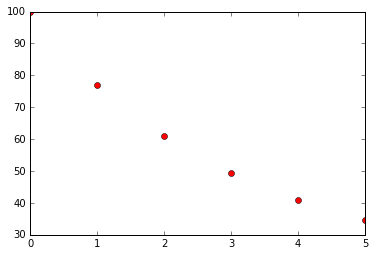

In [91]:
plt.plot(tsteps, qm, "ro")

- [`plot()` function](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) - documentação da função `plot()`

### functions

Recaping the hiperbolic decline curve equation

$$q = \frac{q_i}{(1 + n a_i t)^{1/n}}$$

Let's write it as a Python funciton:

In [92]:
def hiperb_decline(t, qi, ai, n):
    '''
    Calculate instante flow rate of a well using hiperbolic decline
    '''
    q = qi / (1 + n * ai * t) ** (1 / n)
    return q    

Testing it:

In [93]:
hiperb_decline(2, 100, 0.3, 1/3)

57.87037037037038

Our arrays support arithmetic operators, so we could call the above function with a scalar or a vector: 

In [94]:
hiperb_decline(tsteps, 100, 0.3, 1/3)

array([ 100.        ,   75.13148009,   57.87037037,   45.51661356,
         36.44314869,   29.62962963])

## Solution (item 1): Fitting well history data

We will use [curve_fit][curve-fit] function from [SciPy][scipy-ref] library to find decline curve parameters for our well history data.

[scipy-ref]: http://docs.scipy.org/doc/scipy-0.14.0/reference/index.html
[curve-fit]: http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.curve_fit.html

In [95]:
import scipy.optimize

params, fitted = scipy.optimize.curve_fit(hiperb_decline, tsteps, qm, p0=[100, 0.3, 1/3])
qi_fit, ai_fit, n_fit = params

In [96]:
print("Qi: %.2f" % qi_fit)
print("Ai: %.2f" % ai_fit)
print("n:  %.2f" % n_fit)

Qi: 100.01
Ai: 0.28
n:  0.49


**Answer 1:** the curve parameters to fit well production history is $Q_i = 100, a_i = 0.28, n = 0.49$

Let's plot this curve againts well history data to visualize if it really fits:

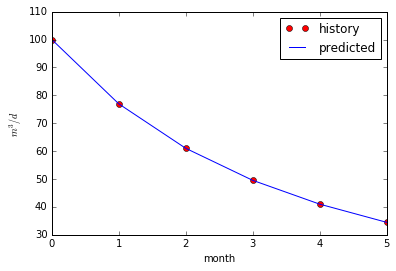

In [97]:
qs = hiperb_decline(tsteps, qi_fit, ai_fit, n_fit)
plt.plot(tsteps, qm, "ro", label="history")
plt.plot(tsteps, qs, "b-", label="predicted")
plt.xlabel("month")
plt.ylabel("$m^3/d$")
plt.legend()

<img src="http://i4.tietuku.cn/634147f5300a430a.jpg" width=300px>

#### Links
- [Matplotlib Gallery](http://matplotlib.org/gallery.html) - plot examples with attached source code
- [SciPy - Reference Guide](http://docs.scipy.org/doc/scipy/reference/)
- [Numpy for Matlab users](https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html#general-purpose-equivalents)

### Solution (item 2): Predicting well abandonment

We have many possible solutions for this one, but we choose to calculate it using SciPy [root finding][root_finding-ref] functions.

Since our break-even is 5 m³std/d, we could find the abandonment time by calculating the zero of the equation when $q = 5$. So, from:

$$q = \frac{q_i}{(1 + n a_i t)^{1/n}}$$

we must find the root of: 

$$\frac{q_i}{(1 + n a_i t)^{1/n}} - 5$$

Let's define this function and find its root using bisection method.

[root_finding-ref]: http://docs.scipy.org/doc/scipy/reference/optimize.html#root-finding

In [98]:
def abandonment(t, qa, qi, ai, n):
    return hiperb_decline(t, qi, ai, n) - qa

res = scipy.optimize.bisect(abandonment, 0, 50, (5, 100, 0.28, 0.49))
print("Np: %.2f years" % res)

Np: 24.35 years


**Answer 2:** well abandonment time is 24.35 years

### Solution (item 3): Cumulative production until abandonment



In [100]:
import scipy.integrate

result, error = scipy.integrate.quad(hiperb_decline, 0, 24.3, (qi_fit, ai_fit, n_fit))
Np = result * 365.25 # mult by 365.25 (flow rate is in days, time in years)
print("Np: %.2f" % (Np))

Np: 200394.16


**Answer 3**: cumulative production until abandonment is **200.394 m3**

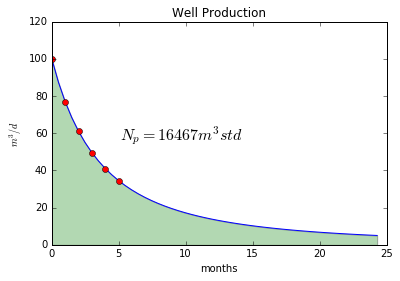

In [83]:
tsteps_a = np.linspace(0, 24.3)
qs_a = hiperb_decline(tsteps_a, qi_fit, ai_fit, n_fit)

plt.plot(tsteps_a, qs_a)      # plot predicted data
plt.plot(tsteps, qm, "ro")    # plot history data
plt.xlabel("months")            
plt.ylabel("$m^3/d $")
plt.title("Well Production")
# And an anotation with well total production, note we could use TeX
plt.annotate(r"$N_p = %.0f m^3std$" % Np, xy=(0.3, 0.5), xycoords='figure fraction', size=16)  
# Color fill predicted data curve
plt.fill_between(tsteps_a, qs_a, 0, facecolor="g", alpha=0.3)
# plt.savefig("declinio.png", dpi=300)

### Bonus Round

In [106]:
import yahoo_finance

brent_share = yahoo_finance.Share("BZN16.NYM")
brent_price = float(brent_share.get_price())
print("Brent Crude Oil: U$ %.2f" % float(brent_price))

Brent Crude Oil: U$ 47.84


In [112]:
m3tobrl = 6.28981077
Np_usd = Np * m3tobrl * brent_price
print("Well predicted Np: U$ %.2f" % Np_usd)

Well predicted Np: U$ 60299512.59
